## Import libraries and init

In [1]:
import uproot
import ROOT
import numpy as np
import pandas as pd
from collections import OrderedDict
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'

Welcome to JupyROOT 6.12/04


In [2]:
import sys
sys.version
sys.version_info

sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)

## Load ntuples from analyzer

In [5]:
masses = [('60','20'),('52p5','5p0'),('6p0','2p0'),('5p25','0p5')]
ctaus = [1]#, 10, 100, 1000]
# triggerPath = 'TRIG_dsa_HLT_DoubleMu3_DCA_PFMET50_PFMHT60'
triggerPath = 'RECO_dsa'
baseDir1 = '../Firefighter/washAOD/GenFilterStudies/'
baseDir2 = '../Firefighter/washAOD/trigger2018Studies/'
fileName1 = lambda Mchi, dMchi, ctau: baseDir1 + f'Mchi-{Mchi}_dMchi-{dMchi}_ctau-{ctau}.root'
fileName2 = lambda Mchi, dMchi, ctau: baseDir2 + f'Mchi-{Mchi}_dMchi-{dMchi}_ctau-{ctau}.root'

numParams = 2*len(masses)*len(ctaus)
countMasses = 0

dfs1 = OrderedDict({})
numEvents1 = OrderedDict({})
for (Mchi, dMchi) in masses:
    countCtaus = 1
    dfs1[Mchi] = OrderedDict({})
    numEvents1[Mchi] = OrderedDict({})
    for ctau in ctaus:
        dfs1[Mchi][ctau] = uproot.open(fileName1(Mchi, dMchi, ctau))[triggerPath + '/recoEffiForMuTrack'].pandas.df()
#         numEvents[Mchi][ctau] = uproot.open(fileName(Mchi, dMchi, ctau))[triggerPath + '/overallInfo'].pandas.df()
        print(f'{countMasses*len(ctaus)+countCtaus} of {numParams}: ' + fileName1(Mchi, dMchi, ctau))
        countCtaus += 1
    countMasses += 1

countMasses = 0
dfs2 = OrderedDict({})
numEvents2 = OrderedDict({})
for (Mchi, dMchi) in masses:
    countCtaus = 1
    dfs2[Mchi] = OrderedDict({})
    numEvents2[Mchi] = OrderedDict({})
    for ctau in ctaus:
        dfs2[Mchi][ctau] = uproot.open(fileName2(Mchi, dMchi, ctau))[triggerPath + '/recoEffiForMuTrack'].pandas.df()
#         numEvents[Mchi][ctau] = uproot.open(fileName(Mchi, dMchi, ctau))[triggerPath + '/overallInfo'].pandas.df()
        print(f'{countMasses*len(ctaus)+countCtaus+numParams//2} of {numParams}: ' + fileName2(Mchi, dMchi, ctau))
        countCtaus += 1
    countMasses += 1

1 of 8: ../Firefighter/washAOD/GenFilterStudies/Mchi-60_dMchi-20_ctau-1.root
2 of 8: ../Firefighter/washAOD/GenFilterStudies/Mchi-52p5_dMchi-5p0_ctau-1.root
3 of 8: ../Firefighter/washAOD/GenFilterStudies/Mchi-6p0_dMchi-2p0_ctau-1.root
4 of 8: ../Firefighter/washAOD/GenFilterStudies/Mchi-5p25_dMchi-0p5_ctau-1.root
5 of 8: ../Firefighter/washAOD/trigger2018Studies/Mchi-60_dMchi-20_ctau-1.root
6 of 8: ../Firefighter/washAOD/trigger2018Studies/Mchi-52p5_dMchi-5p0_ctau-1.root
7 of 8: ../Firefighter/washAOD/trigger2018Studies/Mchi-6p0_dMchi-2p0_ctau-1.root
8 of 8: ../Firefighter/washAOD/trigger2018Studies/Mchi-5p25_dMchi-0p5_ctau-1.root


In [4]:
def extract_teffi(eff):
    _ = ROOT.TCanvas()
    eff.Draw()
    ROOT.gPad.Update()
    
    tot = eff.GetTotalHistogram()
    nBins = tot.GetNbinsX()
    xx = []
    yy = []
    yl = []
    yu = []
    for i in range(1, nBins+1):
        if eff.GetEfficiency(eff.GetGlobalBin(i)) == 0 and eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i)) == 1.: continue
        if eff.GetEfficiency(eff.GetGlobalBin(i)) == 1. and eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)) == 1.: continue
        
        xx.append(tot.GetXaxis().GetBinCenter(i))
        yy.append(eff.GetEfficiency(eff.GetGlobalBin(i)))
        yl.append(eff.GetEfficiencyErrorLow(eff.GetGlobalBin(i)))
        yu.append(eff.GetEfficiencyErrorUp(eff.GetGlobalBin(i)))
                  
    
    return {'x': np.array(xx),
            'y': np.array(yy),
            'yerr': np.array([yl, yu])}

Fit function $f(x) = \frac{1}{1+e^{-p_{0} (x - p_{1})}}  p_{2}$

In [5]:
def extract_fitParam_from_teffi(eff):
    _ = ROOT.TCanvas()
    eff.Draw()
    
    myfit = ROOT.TF1('myfit_', '[2]/(1+exp(-[0]*(x-[1])))', 0, 60)
    myfit.SetParameters(0.02, 4, 0.02)
    eff.Fit(myfit)

    return [myfit.GetParameter(i) for i in range(3)]

In [7]:
df = dfs['60'][1]
# recoDf = df.dropna()
df

nMatched      genPt    genEta    genPhi    genVxy     genVz  \
entry subentry                                                                
0     0              1.0  24.528498 -2.107949 -2.586337  0.039533 -3.454822   
      1              NaN   1.192447 -1.855802 -0.533213  0.039533 -3.454822   
1     0              2.0   4.587510 -1.271550 -2.688952  0.058524  1.909170   
      1              NaN   8.511269 -0.078822  0.401910  0.058524  1.909170   
2     0              2.0  28.961424 -0.602546 -1.946819  0.406182  3.287155   
      1              NaN  20.437332 -0.121153 -1.891687  0.406182  3.287155   
3     0              2.0  45.667805 -0.757121 -1.805508  0.034745 -3.022838   
      1              NaN  11.978521 -0.555156 -2.105438  0.034745 -3.022838   
4     0              1.0  26.878290  0.017129 -1.522783  0.428270  3.497174   
      1              NaN   1.779718 -1.152101 -0.287584  0.428270  3.497174   
5     0              2.0  19.551476  1.448311 -1.374264  0.526622  3.293535   
      1              NaN  12.463858  0.769796 -1.365040  0.526622  3.293535   
6     0              2.0  42.506088  0.656582  0.526626  0.656486  1.686437   
      1              NaN   5.204739  1.567653  0.658063  0.656486  1.686437   
7     0              2.0  22.318933 -1.660328 -0.213657  0.047098 -2.506201   
      1              NaN   8.162837 -2.313897  0.266079  0.047098 -2.506201   
8     0              2.0  34.936256 -1.605464 -2.208477  0.008095  0.549205   
      1              NaN  12.735039 -1.835662 -1.744490  0.008095  0.549205   
9     0              2.0   3.337338 -1.652550 -0.000322  0.049617 -1.467367   
      1              NaN   6.383051 -1.147390 -0.295886  0.049617 -1.467367   
10    0              2.0  16.053925  1.859637  0.734598  0.295393 -3.234269   
      1              NaN   5.552191  0.894750  1.176667  0.295393 -3.234269   
11    0              2.0   7.201940  2.368815  1.978718  0.084158 -1.144300   
      1              NaN  13.703901  1.713866  1.596098  0.084158 -1.144300   
12    0              2.0   8.198837  1.307737  0.272445  0.407645  3.536646   
      1              NaN   8.974521  1.106019  1.402898  0.407645  3.536646   
13    0              2.0  24.437016 -0.452517  1.526857  0.054518 -2.888953   
      1              NaN   7.876246  0.507340  1.696980  0.054518 -2.888953   
14    0              1.0   8.703342  0.872806 -2.380160  0.040728 -1.180741   
      1              NaN   2.292416 -0.021492 -2.888024  0.040728 -1.180741   
...                  ...        ...       ...       ...       ...       ...   
18115 0              2.0   6.678517 -1.422211 -0.368332  0.174788 -5.553589   
      1              NaN  15.955467 -1.253107 -0.382869  0.174788 -5.553589   
18116 0              1.0   6.969681  0.294161  1.395161  0.046364 -4.401179   
      1              NaN   2.407931 -0.335007  0.902065  0.046364 -4.401179   
18117 0              2.0   4.626480 -1.518038  2.639603  0.041131  3.591740   
      1              NaN  10.105056 -0.367976 -3.099738  0.041131  3.591740   
18118 0              2.0   9.304181 -1.059127 -1.423364  0.035606  2.168598   
      1              NaN  13.518148 -0.282991 -1.514905  0.035606  2.168598   
18119 0              2.0  51.567623  1.047444 -0.683076  1.062887  2.348608   
      1              NaN  19.597071  0.992353 -0.683976  1.062887  2.348608   
18120 0              1.0  15.620556 -0.876200 -2.442557  0.043750 -0.569568   
      1              NaN   1.485463  1.369108 -2.911079  0.043750 -0.569568   
18121 0              1.0  46.617752  0.056855 -2.164124  0.036140 -8.088213   
      1              NaN   3.660150  0.382516 -2.817025  0.036140 -8.088213   
18122 0              2.0   2.886331  2.224484 -2.365757  0.042456  3.252565   
      1              NaN  13.955026  2.376456 -0.879795  0.042456  3.252565   
18123 0              2.0   7.307077  0.653953 -1.208357  0.042457 -1.628421   
      1              NaN  17.752232  1.004852 -2.139418  0.042457 

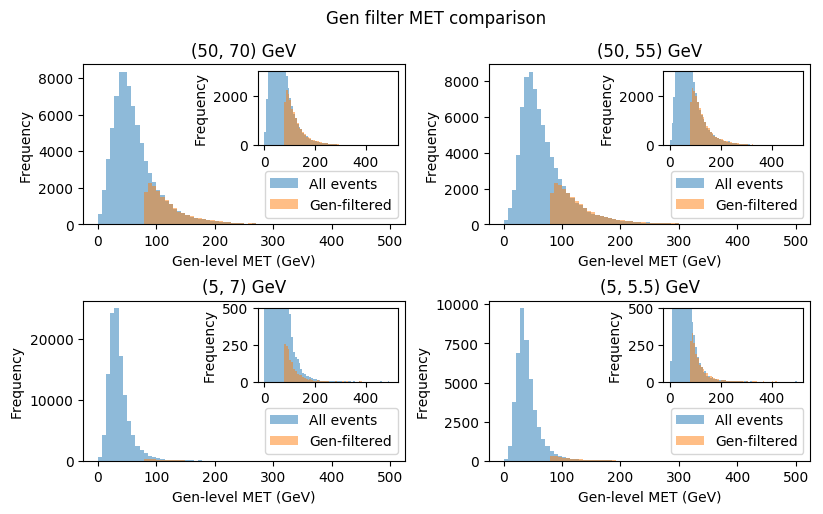

In [6]:
fig, axes = plt.subplots(2,2, figsize=(8,5))

fig.suptitle("Gen filter MET comparison")
plt.tight_layout(h_pad=4.0, w_pad=3.0)
fig.subplots_adjust(top=0.87)

labels = [['(50, 70) GeV', '(50, 55) GeV'], \
          [ '(5, 7) GeV', '(5, 5.5) GeV']]

ranges = [[[0,3000], [0,3000]], \
          [[0,500], [0,500]]]

variables = [['60', '52p5'], \
             ['6p0', '5p25']]

properties = {'bins':50, 'density':True, 'log':True, 'alpha':0.5}

for i in range(len(labels)):
    for (j, label) in enumerate(labels[i]):
        properties['range'] = (ranges[i][j])
        properties['label'] = 'all'
        dfs2[variables[i][j]][1]['genLeadMetPt'].plot.hist(ax=axes[i,j],bins=70,range=(0,500), alpha=0.5, label='All events', density=False)
        dfs1[variables[i][j]][1]['genLeadMetPt'].plot.hist(ax=axes[i,j],bins=70,range=(0,500), alpha=0.5, label='Gen-filtered', density=False)
        axes[i,j].legend(loc='lower right')
        axes[i,j].set_title(labels[i][j])
        axes[i,j].set_xlabel('Gen-level MET (GeV)')
#         a = axes[i,j].axes([.55, .5, .3, .3])
        axins = inset_axes(axes[i,j], width=1.4, height=0.74)
        dfs2[variables[i][j]][1]['genLeadMetPt'].plot.hist(bins=70,ylim=ranges[i][j],range=(0,500), alpha=0.5, label='All events', density=False)
        dfs1[variables[i][j]][1]['genLeadMetPt'].plot.hist(bins=70,ylim=ranges[i][j],range=(0,500), alpha=0.5, label='Gen-filtered', density=False)
#         axes[i,j].hist(recoDf[variables[i][j]][:,0], **properties)
#         properties['label'] = 'fired'
#         axes[i,j].hist(recoDf.query(query)[variables[i][j]], **properties)
#         axes[i,j].set_xlabel(label)
#         axes[i,j].legend(loc='upper right')
#         axes[i,j].grid()

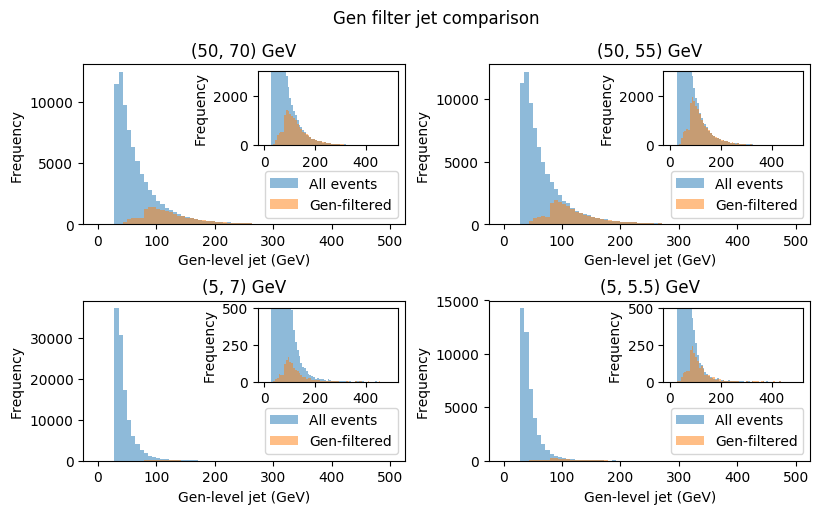

In [41]:
fig, axes = plt.subplots(2,2, figsize=(8,5))

fig.suptitle("Gen filter jet comparison")
plt.tight_layout(h_pad=4.0, w_pad=3.0)
fig.subplots_adjust(top=0.87)

labels = [['(50, 70) GeV', '(50, 55) GeV'], \
          [ '(5, 7) GeV', '(5, 5.5) GeV']]

ranges = [[[0,3000], [0,3000]], \
          [[0,500], [0,500]]]

variables = [['60', '52p5'], \
             ['6p0', '5p25']]

properties = {'bins':50, 'density':True, 'log':True, 'alpha':0.5}

for i in range(len(labels)):
    for (j, label) in enumerate(labels[i]):
        properties['range'] = (ranges[i][j])
        properties['label'] = 'all'
        dfs2[variables[i][j]][1]['genJetPt'].plot.hist(ax=axes[i,j],bins=70,range=(0,500), alpha=0.5, label='All events', density=False)
        dfs1[variables[i][j]][1]['genJetPt'].plot.hist(ax=axes[i,j],bins=70,range=(0,500), alpha=0.5, label='Gen-filtered', density=False)
        axes[i,j].legend(loc='lower right')
        axes[i,j].set_title(labels[i][j])
        axes[i,j].set_xlabel('Gen-level jet (GeV)')
#         a = axes[i,j].axes([.55, .5, .3, .3])
        axins = inset_axes(axes[i,j], width=1.4, height=0.74)
        dfs2[variables[i][j]][1]['genJetPt'].plot.hist(bins=70,ylim=ranges[i][j],range=(0,500), alpha=0.5, label='All events', density=False)
        dfs1[variables[i][j]][1]['genJetPt'].plot.hist(bins=70,ylim=ranges[i][j],range=(0,500), alpha=0.5, label='Gen-filtered', density=False)
#         axes[i,j].hist(recoDf[variables[i][j]][:,0], **properties)
#         properties['label'] = 'fired'
#         axes[i,j].hist(recoDf.query(query)[variables[i][j]], **properties)
#         axes[i,j].set_xlabel(label)
#         axes[i,j].legend(loc='upper right')
#         axes[i,j].grid()

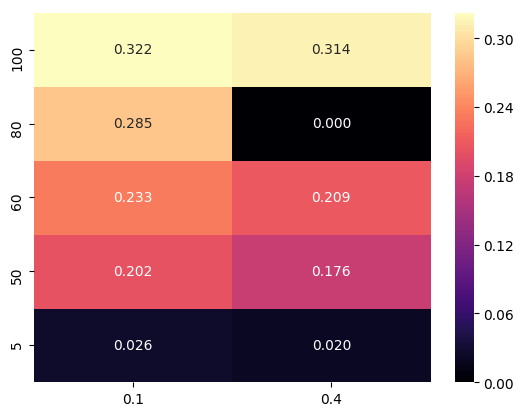

In [33]:
data=[[0.0260371, 0.020225], [0.201582, 0.175725], [0.233245, 0.208775], [0.28456, 0], [0.322382, 0.313771]]
masslabels=['5', '50', '60', '80', '100']
splitlabels=['0.1', '0.4']
ctaulabels = ['1']

sns.heatmap(data[::-1], cmap='magma', yticklabels=masslabels[::-1], xticklabels=splitlabels, annot=True, fmt=".3f")

# Making gen-level efficiency table

In [33]:
data = pd.read_csv('../Firefighter/washAOD/GenFilterStudies/outputs/samples.dat', sep=' ', header=None)
data.rename(columns={0:'Sample',1:'Efficiency'},inplace=True)

In [34]:
data['Mchi'] = data['Sample'].str.split('_').str[0].str.split('-').str[1].str.replace('p','.').astype(float)
data['dMchi'] = data['Sample'].str.split('_').str[1].str.split('-').str[1].str.replace('p','.').astype(float)
data['m1'] = data['Mchi'].astype(float) - data['dMchi'].astype(float)/2
data['m1'] = data['m1'].astype(int)
data = data.sort_values(by='Mchi')

In [35]:
def calcm1(x):
    m1 = float(x['Mchi']) - float(x['dMchi'])/2
    m2 = float(x['Mchi']) + float(x['dMchi'])/2
    return f'{m1} GeV'

data['Labels'] = data.apply(calcm1, axis=1)

In [36]:
data

,Sample,Efficiency,Mchi,dMchi,m1,Labels
4,Mchi-1p2_dMchi-0p4_ctau-1.out,0.015624,1.20,0.4,1,1.0 GeV
9,Mchi-3p15_dMchi-0p3_ctau-1.out,0.025204,3.15,0.3,3,3.0 GeV
10,Mchi-3p6_dMchi-1p2_ctau-1.out,0.018632,3.60,1.2,3,3.0 GeV
14,Mchi-5p25_dMchi-0p5_ctau-1.out,0.026037,5.25,0.5,5,5.0 GeV
17,Mchi-6p0_dMchi-2p0_ctau-1.out,0.020225,6.00,2.0,5,5.0 GeV
1,Mchi-10p5_dMchi-1p0_ctau-1.out,0.038406,10.50,1.0,10,10.0 GeV
3,Mchi-12p0_dMchi-4p0_ctau-1.out,0.029325,12.00,4.0,10,10.0 GeV
5,Mchi-21p0_dMchi-2p0_ctau-1.out,0.077048,21.00,2.0,20,20.0 GeV
6,Mchi-24p0_dMchi-8p0_ctau-1.out,0.061580,24.00,8.0,20,20.0 GeV
7,Mchi-31p5_dMchi-3p0_ctau-1.out,0.119022,31.50,3.0,30,30.0 GeV


In [37]:
split40pcent = data.query('Mchi-dMchi/2 == 2.5*dMchi')
split10pcent = data.query('Mchi-dMchi/2 == 10*dMchi')

In [38]:
plotdf=pd.concat([split10pcent[['m1','Efficiency']].set_index('m1'), \
                  split40pcent[['m1','Efficiency']].set_index('m1')], axis=1)

In [39]:
plotdf.columns=['$\Delta$ = 0.1 m1', '$\Delta$ = 0.4 m1']
plotdf.index.names = ['m1 (GeV)']
plotdf.columns.names = ['Mass splitting']
plotdf

Mass splitting,$\Delta$ = 0.1 m1,$\Delta$ = 0.4 m1
m1 (GeV),,
1,NaN,0.015624
3,0.025204,0.018632
5,0.026037,0.020225
10,0.038406,0.029325
20,0.077048,0.061580
30,0.119022,0.098161
40,0.161960,0.138853
50,0.201635,0.175725
60,0.233127,0.208775


(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5]), <a list of 11 Text yticklabel objects>)

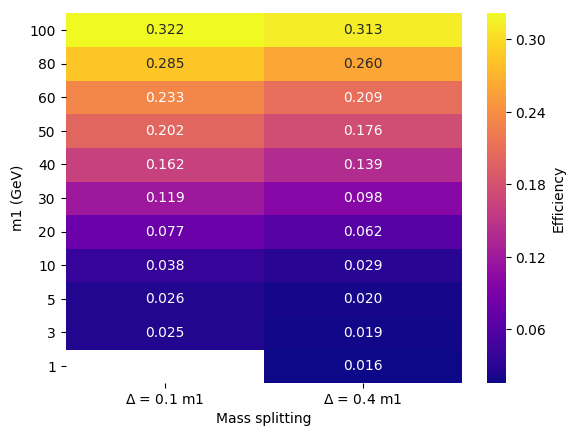

In [40]:
sns.heatmap(plotdf[::-1], cmap='plasma', annot=True, fmt='.3f', cbar_kws={'label': 'Efficiency'})
plt.yticks(rotation=0)